In [2]:
import pandas as pd
import numpy as np
import logging as logger
import time
from distributed import Client
import matplotlib.pyplot as plt

import dask_awkward as dak
import awkward as ak
from basic_class_for_calibration import get_calib_categories
from basic_class_for_calibration import closure_test_from_calibrated_df

In [5]:
# 2018C
# out_string = "2018C"
# NEW_INPUT_DATASET = "/depot/cms/users/shar1172/hmm/copperheadV1clean/Run2_nanoAODv12_24Feb_BSon//stage1_output/2018/f1_0/data_C/*/part*.parquet"

# out_string = "_2018C_12March"
# NEW_INPUT_DATASET = "/depot/cms/users/shar1172/hmm/copperheadV1clean/Run2_nanoAODv12_12March_GeoFit//stage1_output/2018/f1_0/data_C/0/part*.parquet"

# # 2022preEE_C
out_string = "_2022preEE"
# NEW_INPUT_DATASET = "/depot/cms/users/shar1172/hmm/copperheadV1clean/Run3_nanoAODv12_BSOn_UpdateMassCalib//stage1_output/2022preEE/f1_0/data_*/*/*.parquet"
NEW_INPUT_DATASET = "/depot/cms/users/shar1172/hmm/copperheadV1clean/Run2_nanoAODv12_12March_BSC/stage1_output/2022preEE/f1_0/data_*/*/*.parquet"



In [6]:
fit_csv_path = f"/depot/cms/private/users/shar1172/copperheadV2/fit_results{out_string}.csv"
df_fit = pd.read_csv(fit_csv_path)
print(df_fit)

          cat_name   fit_val   fit_err
0   30-45_BB_OB_EB  0.874056  0.010066
1   30-45_BO_OO_EO  0.957253  0.014582
2   30-45_BE_OE_EE  1.362861  0.018658
3         45-52_BB  0.681190  0.000334
4         45-52_BO  0.931971  0.025202
5         45-52_BE  1.219466  0.066318
6         45-52_OB  0.969647  0.022460
7         45-52_OO  1.156803  0.000177
8         45-52_OE  1.503936  0.031385
9         45-52_EB  1.231944  0.080239
10        45-52_EO  1.503010  0.000108
11        45-52_EE  1.736523  0.040048
12        52-62_BB  0.801561  0.009270
13        52-62_BO  1.053149  0.014336
14        52-62_BE  1.399129  0.032161
15        52-62_OB  1.098931  0.014185
16        52-62_OO  1.450678  0.011852
17        52-62_OE  1.576759  0.022259
18        52-62_EB  1.504830  0.102550
19        52-62_EO  1.879970  0.020757
20        52-62_EE  2.151637  0.026843
21       62-200_BB  0.840869  0.009794
22       62-200_BO  1.102631  0.015208
23       62-200_BE  1.337953  0.046744
24       62-200_OB  1.123

In [7]:
from basic_class_for_calibration import filter_region

def fetch_Hmm_resolution(parquet_path):
    print("=== Step 6: Fetch variable dimuon_ebe_mass_res from parquet in calibration categories ===")
    tstart = time.time()

    # Start a Dask distributed client.
    client = Client(n_workers=4, threads_per_worker=1, processes=True, memory_limit='8 GiB')
    
    # Load the data with dask_awkward.
    data_events = dak.from_parquet(parquet_path)

    # Apply a ZCR filter
    # region_filter = ak.fill_none(data_events["z_peak"], value=False)
    # data_events = data_events[region_filter]
    data_events = filter_region(data_events, "z_peak")

    print(data_events)

    # Only select the fields needed for calibration (muon1 and muon2 eta, pt, and dimuon mass)
    fields_of_interest = ["mu1_pt", "mu1_eta", "mu2_eta", "dimuon_mass", "dimuon_ebe_mass_res"]
    data_events = data_events[fields_of_interest]

    # Bring the data into memory as an Awkward array.
    # data_events = ak.zip({field: data_events[field] for field in data_events.fields}).compute()
    data_events = data_events.compute()

    print(data_events)

    # Build calibration category masks.
    calib_cats = get_calib_categories(data_events)
    print(f"Total number of categories (Step 1): {len(calib_cats)}")


    res_results = []
    # for cat_name, mask in calib_cats.items():
    for cat_name, mask in calib_cats.items():
        # print(f"cat: {cat_name}, mask: {mask}")
        cat_dimuon_mass_res = ak.to_numpy(data_events["dimuon_ebe_mass_res"][mask])

        # print(cat_dimuon_mass_res)
        # print(type(cat_dimuon_mass_res))

        # print("median: ",np.median(cat_dimuon_mass_res))
        
        median_val = np.median(cat_dimuon_mass_res)
        res_results.append({"cat_name": cat_name, "median_val": median_val})
        plt.figure()
        plt.hist(cat_dimuon_mass_res, bins=100, range=(0, 5.0), color='C0', alpha=0.7)
        plt.xlabel('Dimuon mass resolution (GeV)')
        plt.ylabel('Events')
        plt.title(f"Category {cat_name}\nMedian = {median_val:.4f} GeV")
        plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2,
                    label=f"Median: {median_val:.4f} GeV")
        plt.legend()
        plt.savefig(f'mass_resolution_{cat_name}.png')
        plt.close()
        print(f"Saved histogram for category {cat_name} (median = {median_val:.4f} GeV)")

    logger.info("Step 2 completed in {:.2f} seconds.".format(time.time() - tstart))
    df_res = pd.DataFrame(res_results)
    return df_res



In [8]:
df_calibrated = fetch_Hmm_resolution(NEW_INPUT_DATASET)

=== Step 6: Fetch variable dimuon_ebe_mass_res from parquet in calibration categories ===
dask.awkward<getitem, npartitions=779>
[{mu1_pt: 47.4, mu1_eta: -2.21, mu2_eta: -2.06, dimuon_mass: 90.4, ...}, ...]
Total number of categories (Step 1): 30


/depot/cms/kernels/coffea_latest/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Saved histogram for category 30-45_BB_OB_EB (median = 0.8177 GeV)
Saved histogram for category 30-45_BO_OO_EO (median = 0.8992 GeV)
Saved histogram for category 30-45_BE_OE_EE (median = 1.2707 GeV)
Saved histogram for category 45-52_BB (median = 0.6353 GeV)
Saved histogram for category 45-52_BO (median = 0.8686 GeV)
Saved histogram for category 45-52_BE (median = 1.1513 GeV)
Saved histogram for category 45-52_OB (median = 0.9024 GeV)
Saved histogram for category 45-52_OO (median = 1.0802 GeV)
Saved histogram for category 45-52_OE (median = 1.3976 GeV)
Saved histogram for category 45-52_EB (median = 1.1419 GeV)
Saved histogram for category 45-52_EO (median = 1.3852 GeV)
Saved histogram for category 45-52_EE (median = 1.5567 GeV)
Saved histogram for category 52-62_BB (median = 0.7449 GeV)
Saved histogram for category 52-62_BO (median = 0.9805 GeV)
Saved histogram for category 52-62_BE (median = 1.3200 GeV)
Saved histogram for category 52-62_OB (median = 1.0193 GeV)
Saved histogram for ca

In [9]:
df_calibrated.to_csv("calibrated_mass_resolution.csv", index=False)

In [10]:
closure_test_from_calibrated_df(df_fit, df_calibrated, "_UpdatedCalib"+out_string)

Closure test plot saved as closure_test__UpdatedCalib_2022preEE.pdf


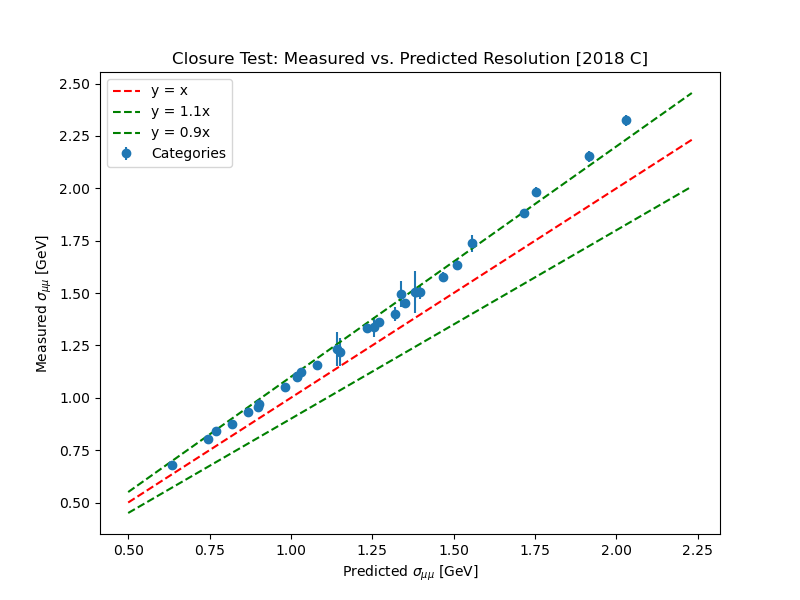

In [11]:
from IPython.display import Image, display
display(Image(filename='closure_test__UpdatedCalib_2022preEE.png'))


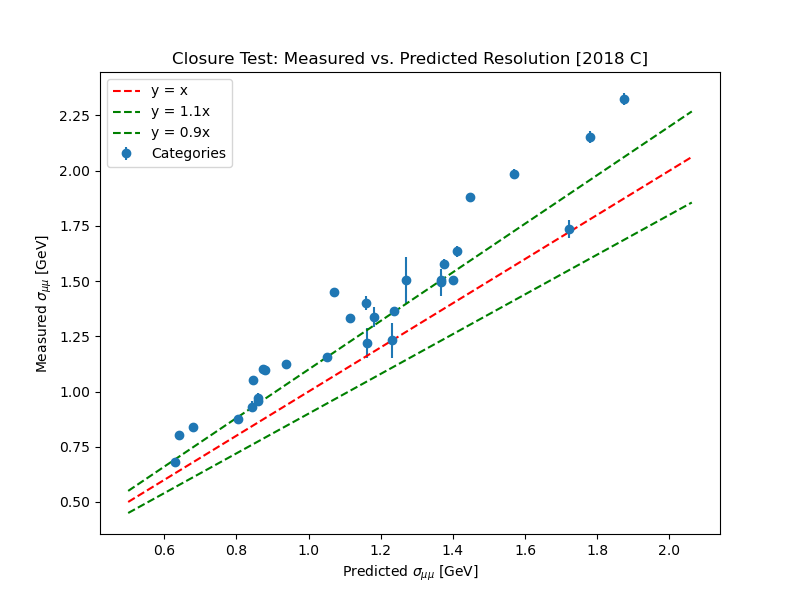

In [8]:
from IPython.display import Image, display
display(Image(filename='closure_test__UpdatedCalib_2022preEE.png'))


In [9]:
from IPython.display import FileLink

# Replace 'your_plot.png' with your file's path
display(FileLink('closure_test__UpdatedCalib_2022preEE.pdf'))


/depot/cms/private/users/shar1172/copperheadV2/src/lib/ebeMassResCalibration/closure_test__UpdatedCalib_2022preEE.pdf